<a href="https://colab.research.google.com/github/tantn89/Austin_Airbnb_Investment/blob/main/Milestone_Tan_Tran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
listings = pd.read_csv('http://data.insideairbnb.com/united-states/tx/austin/2022-12-15/data/listings.csv.gz', compression='gzip')
calendar = pd.read_csv('http://data.insideairbnb.com/united-states/tx/austin/2022-12-15/data/calendar.csv.gz', compression='gzip')
reviews = pd.read_csv('http://data.insideairbnb.com/united-states/tx/austin/2022-12-15/data/reviews.csv.gz', compression='gzip')
neighborhoods = pd.read_csv('http://data.insideairbnb.com/united-states/tx/austin/2022-12-15/visualisations/neighbourhoods.csv')

# Clean Data

In [ ]:
# Drop irrelevant columns or columns with too many missing values
columns_to_keep = [
    'id', 'host_id', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text',
    'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating',
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value', 'reviews_per_month'
]
listings = listings[columns_to_keep]
calendar = calendar[['listing_id', 'date', 'available', 'price']]
reviews = reviews[['listing_id', 'date', 'reviewer_id', 'comments']]

# Fill missing values or drop rows with missing values depending on the column.
listings.fillna({'bedrooms': 0, 'beds': 0, 'reviews_per_month': 0}, inplace=True)
listings.dropna(subset=['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], inplace=True)
calendar.dropna(subset=['price'], inplace=True)
reviews.dropna(subset=['comments'], inplace=True)

# Convert data types if needed
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['available'] = calendar['available'].map({'t': True, 'f': False})
calendar['price'] = calendar['price'].str.replace('$', '', regex=True).str.replace(',', '', regex=True).astype(float)
listings['price'] = listings['price'].str.replace('[^\d\.]', '', regex=True).astype(float)
reviews['date'] = pd.to_datetime(reviews['date'])

# Visualize Data

## Total Revenue by Neighbourhood

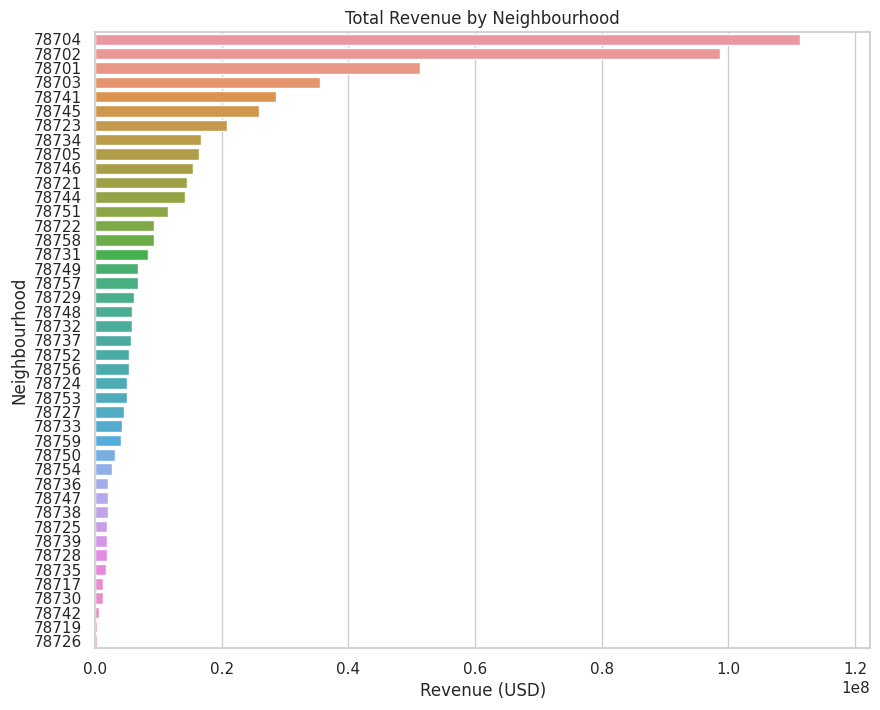

In [ ]:
# Merge the calendar dataset with the listings dataset to get the host_id
merged_data_all_years = calendar.merge(listings[['id', 'host_id', 'neighbourhood_cleansed']], left_on='listing_id', right_on='id')
merged_data_all_years['year'] = pd.to_datetime(merged_data_all_years['date']).dt.year
merged_data_all_years['month'] = pd.to_datetime(merged_data_all_years['date']).dt.month

# Calculate the revenue for each listing
merged_data_all_years['revenue'] = np.where(merged_data_all_years['available'] == False, merged_data_all_years['price'], 0)

# Group the data by neighbourhood_cleansed and sum the revenue
neighbourhood_revenue_all_years = merged_data_all_years.groupby('neighbourhood_cleansed')['revenue'].sum().reset_index()

# Sort the data by the revenue
neighbourhood_revenue_all_years = neighbourhood_revenue_all_years.sort_values(by='revenue', ascending=False)

# Display the total revenue by neighbourhood
sns.set(style='whitegrid')
plt.figure(figsize=(10, 8))
sns.barplot(x='revenue', y='neighbourhood_cleansed', data=neighbourhood_revenue_all_years, order=neighbourhood_revenue_all_years['neighbourhood_cleansed'], dodge=False, orient='h')
plt.title('Total Revenue by Neighbourhood')
plt.xlabel('Revenue (USD)')
plt.ylabel('Neighbourhood')
plt.xlim(0, neighbourhood_revenue_all_years['revenue'].max()*1.1)  # Set the x-axis limits to include the maximum revenue value
plt.show()

## Total Bookings by Neighbourhood

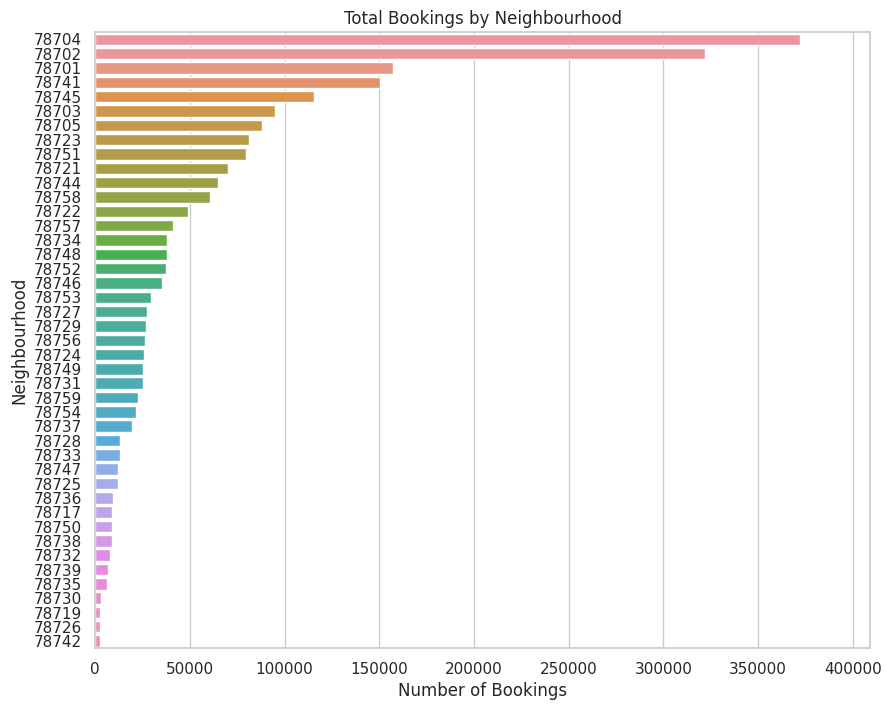

In [ ]:
# Merge the calendar dataset with the listings dataset to get the host_id
merged_data_all_years = calendar.merge(listings[['id', 'host_id', 'neighbourhood_cleansed']], left_on='listing_id', right_on='id')
merged_data_all_years['year'] = pd.to_datetime(merged_data_all_years['date']).dt.year
merged_data_all_years['month'] = pd.to_datetime(merged_data_all_years['date']).dt.month

# Count the number of bookings for each listing
merged_data_all_years['bookings'] = np.where(merged_data_all_years['available'] == False, 1, 0)

# Group the data by neighbourhood_cleansed and sum the number of bookings
neighbourhood_bookings_all_years = merged_data_all_years.groupby('neighbourhood_cleansed')['bookings'].sum().reset_index()

# Sort the data by the number of bookings
neighbourhood_bookings_all_years = neighbourhood_bookings_all_years.sort_values(by='bookings', ascending=False)

# Display the total number of bookings by neighbourhood
sns.set(style='whitegrid')
plt.figure(figsize=(10, 8))
sns.barplot(x='bookings', y='neighbourhood_cleansed', data=neighbourhood_bookings_all_years, order=neighbourhood_bookings_all_years['neighbourhood_cleansed'], dodge=False, orient='h')
plt.title('Total Bookings by Neighbourhood')
plt.xlabel('Number of Bookings')
plt.ylabel('Neighbourhood')
plt.xlim(0, neighbourhood_bookings_all_years['bookings'].max()*1.1)  # Set the x-axis limits to include the maximum number of bookings
plt.show()

In [ ]:
## Price Distribution by Neighbourhood

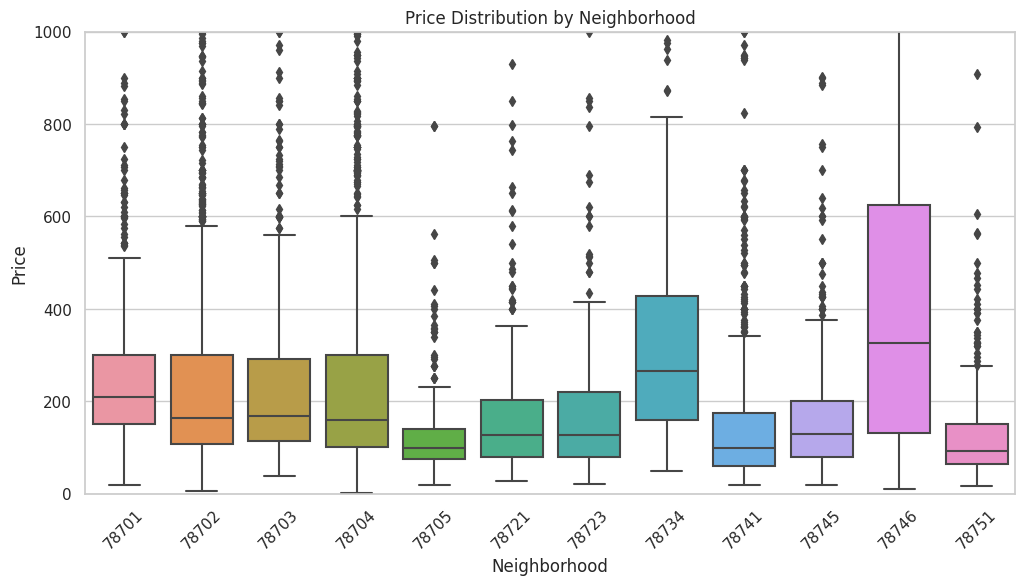

In [ ]:
# List of potitental neighborhoods
neighborhoods_list = [
    78704, 78702, 78701, 78703, 78741, 78745, 78723, 78734, 78705, 78746, 78751, 78721
]

# Filter listings to include only specific neighborhoods
listings_filtered = listings[listings['neighbourhood_cleansed'].isin(neighborhoods_list)]

# Create a boxplot to visualize the price distribution for each neighborhood
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=listings_filtered)
plt.title('Price Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.ylim(0, 1000)  # Set the y-axis limits to 0 and 1000
plt.xticks(rotation=45)
plt.show()

## Host Count by Neighbourhood

In [ ]:
# Group the listings dataset by neighbourhood and count unique hosts
neighborhood_host_counts = listings.groupby('neighbourhood_cleansed')['host_id'].nunique().reset_index().rename(columns={'host_id': 'host_count'})

# Sort the neighborhoods by the number of hosts in descending order and display the top 10
top_10_neighborhoods = neighborhood_host_counts.sort_values(by='host_count', ascending=False).head(10)
display(top_10_neighborhoods)

,neighbourhood_cleansed,host_count
3,78704,1205
1,78702,962
26,78741,480
29,78745,444
2,78703,334
0,78701,299
9,78723,277
35,78751,257
4,78705,236
7,78721,231


## Total Bookings Each Month

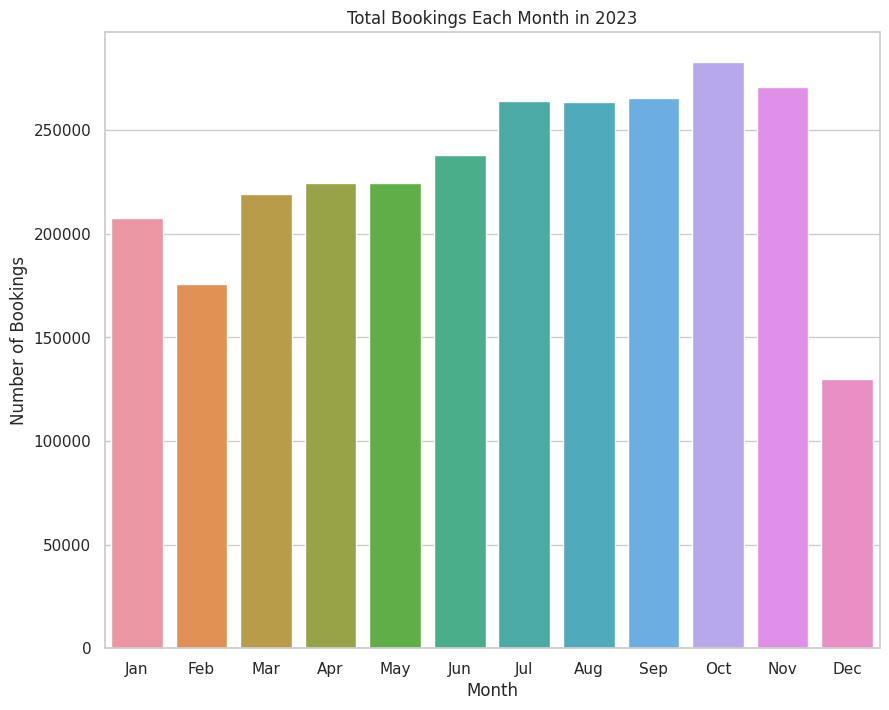

In [ ]:
# Filter the calendar data to include only bookings where 'available' is False
bookings = calendar[calendar['available'] == False]

# Filter the bookings data to include only data from 2023
bookings_2023 = bookings[bookings['date'].dt.year == 2023]

# Group the data by month and count the number of bookings in each month
bookings_by_month = bookings_2023.groupby(bookings_2023['date'].dt.month).size().reset_index(name='count')

# Display the total bookings each month in 2023 on a chart
sns.set(style='whitegrid')
plt.figure(figsize=(10, 8))
sns.barplot(x='date', y='count', data=bookings_by_month)
plt.title('Total Bookings Each Month in 2023')
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## Rating vs Number of Bookings

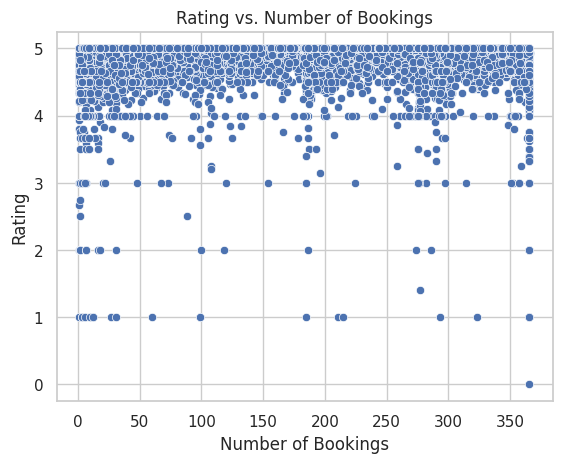

In [ ]:
# Group by listing_id and count the number of bookings per listing
bookings_count = bookings.groupby('listing_id').size().reset_index(name='bookings')

# Merge bookings_count with listings dataset
listings = listings.merge(bookings_count, left_on='id', right_on='listing_id', how='left')

# Create a scatterplot of the relationship between ratings and the number of bookings
sns.scatterplot(data=listings, x='bookings', y='review_scores_rating')
plt.xlabel('Number of Bookings')
plt.ylabel('Rating')
plt.title('Rating vs. Number of Bookings')
plt.show()

## Top Property Types

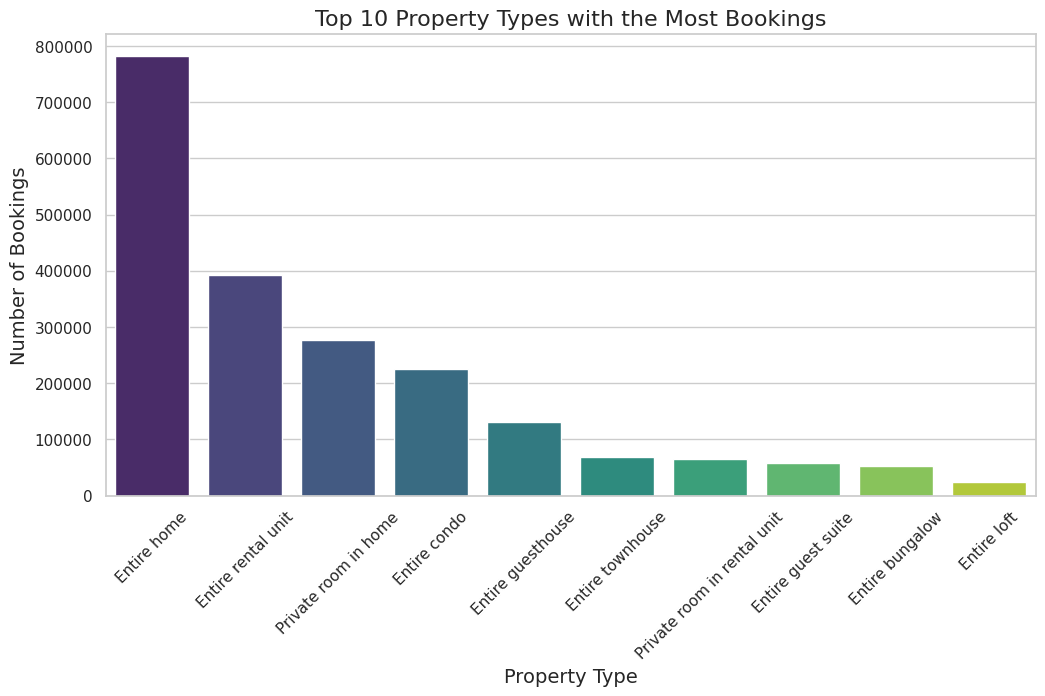

In [ ]:
# Merge the calendar dataset with the listings dataset to get the property_type for each listing
merged_data = calendar.merge(listings[['id', 'property_type']], left_on='listing_id', right_on='id')

# Filter the dataset for booked listings (available == False)
booked_listings = merged_data[merged_data['available'] == False]

# Group the data by property_type and count the number of bookings for each property type
property_type_bookings = booked_listings.groupby('property_type')['booking'].sum().reset_index()

# Sort the results in descending order and display the top 10 property types
top_10_property_types = property_type_bookings.sort_values(by='booking', ascending=False).head(10)

# Create a bar chart of the top 10 property types with the most bookings
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_property_types, x='property_type', y='booking', palette='viridis')
plt.title('Top 10 Property Types with the Most Bookings', fontsize=16)
plt.xlabel('Property Type', fontsize=14)
plt.ylabel('Number of Bookings', fontsize=14)
plt.xticks(rotation=45)
plt.show()

## Price Distribution for Top 10 Property Types

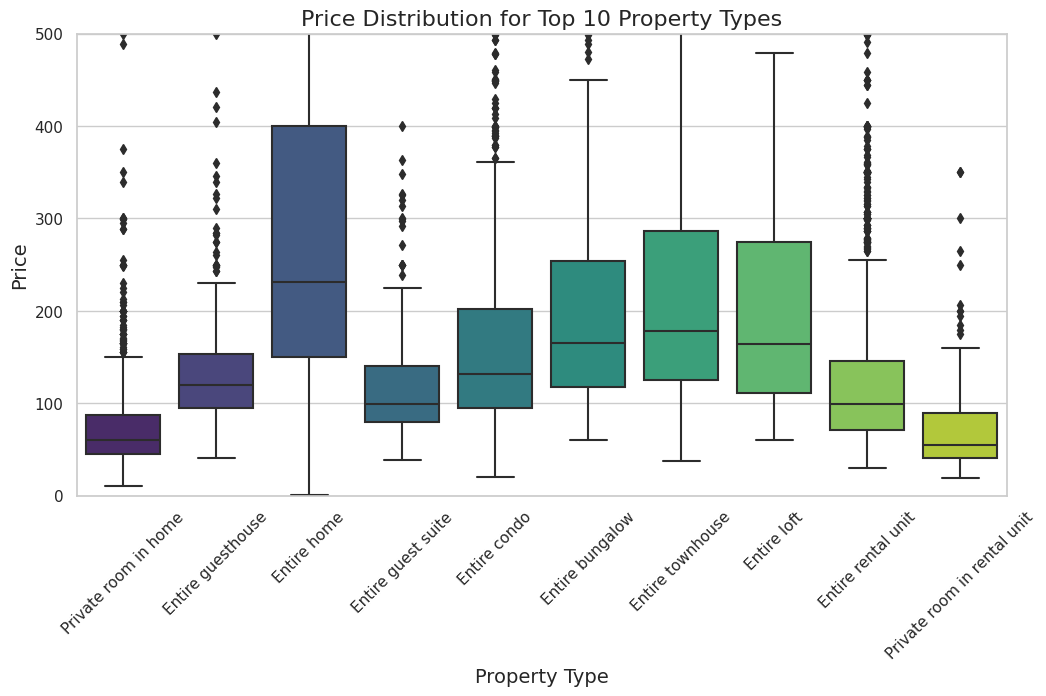

In [ ]:
# Filter the listings dataset for the top 10 property types
top_10_property_types_list = top_10_property_types['property_type'].tolist()
top_10_listings = listings[listings['property_type'].isin(top_10_property_types_list)]

# Create a box plot of the prices for the top 10 property types
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_10_listings, x='property_type', y='price', palette='viridis')

# Customize the chart
plt.title('Price Distribution for Top 10 Property Types', fontsize=16)
plt.xlabel('Property Type', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=45)

# Adjust the y-axis scale
plt.ylim(0, 500)

# Display the chart
plt.show()

## Top Prices with the Most Bookings

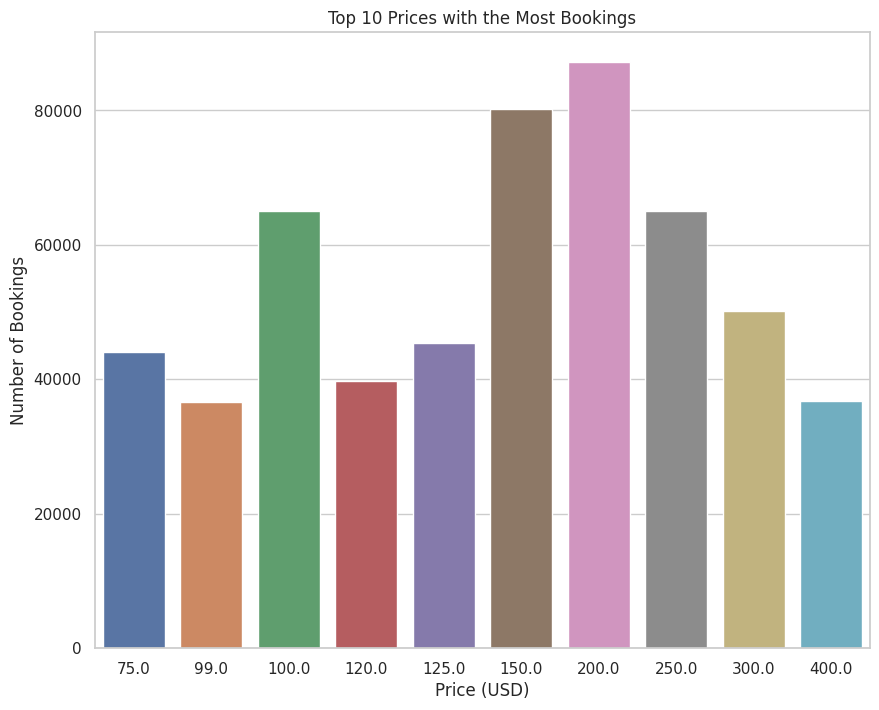

In [ ]:
# Calculate the booking for each date
calendar['booking'] = np.where(calendar['available'] == False, 1, 0)

# Group the data by price and sum the booking for each price
price_bookings = calendar.groupby('price')['booking'].sum().reset_index()

# Sort the data by booking in descending order and get the top 10
top_prices = price_bookings.sort_values(by='booking', ascending=False).head(10)

# Create a bar chart of the top 10 prices and their bookings
sns.set(style='whitegrid')
plt.figure(figsize=(10, 8))
sns.barplot(x='price', y='booking', data=top_prices)
plt.title('Top 10 Prices with the Most Bookings')
plt.xlabel('Price (USD)')
plt.ylabel('Number of Bookings')
plt.show()

## Price vs Bathrooms, Bedrooms, and Beds

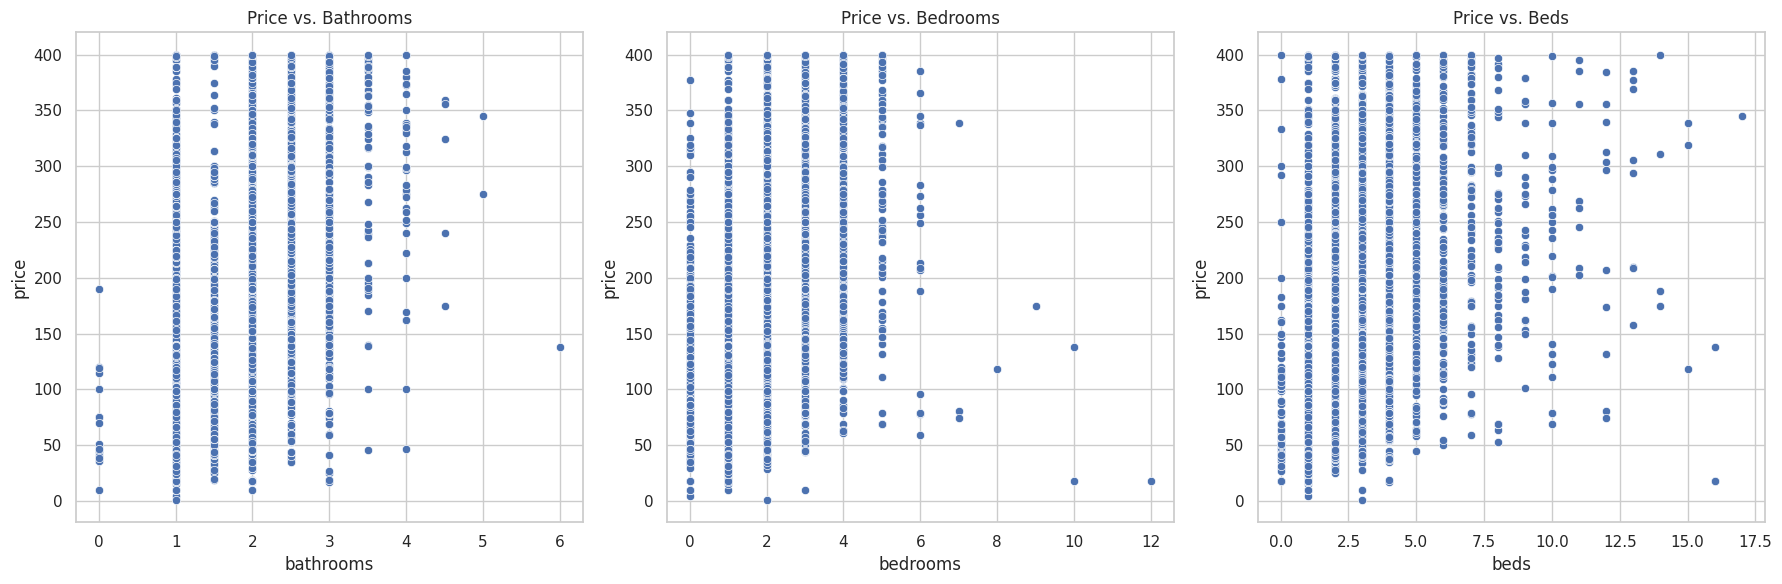

In [ ]:
# Filter listings with price <= 400
listings_filtered = listings[listings['price'] <= 400]

# Select columns of interest
columns_of_interest = ['bathrooms_text', 'bedrooms', 'beds', 'price']
listings_filtered = listings_filtered[columns_of_interest]

# Convert 'bathrooms_text' to numeric 'bathrooms'
listings_filtered['bathrooms'] = listings_filtered['bathrooms_text'].str.extract('(\d+(?:\.\d+)?)', expand=False).astype(float)
listings_filtered.drop('bathrooms_text', axis=1, inplace=True)

# Create scatterplots for each variable
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.scatterplot(data=listings_filtered, x='bathrooms', y='price', ax=axes[0])
axes[0].set_title('Price vs. Bathrooms')

sns.scatterplot(data=listings_filtered, x='bedrooms', y='price', ax=axes[1])
axes[1].set_title('Price vs. Bedrooms')

sns.scatterplot(data=listings_filtered, x='beds', y='price', ax=axes[2])
axes[2].set_title('Price vs. Beds')

plt.tight_layout()
plt.show()

## Relationship between Accommodates and Price

The most popular number of accommodates in the listings dataset is: 2




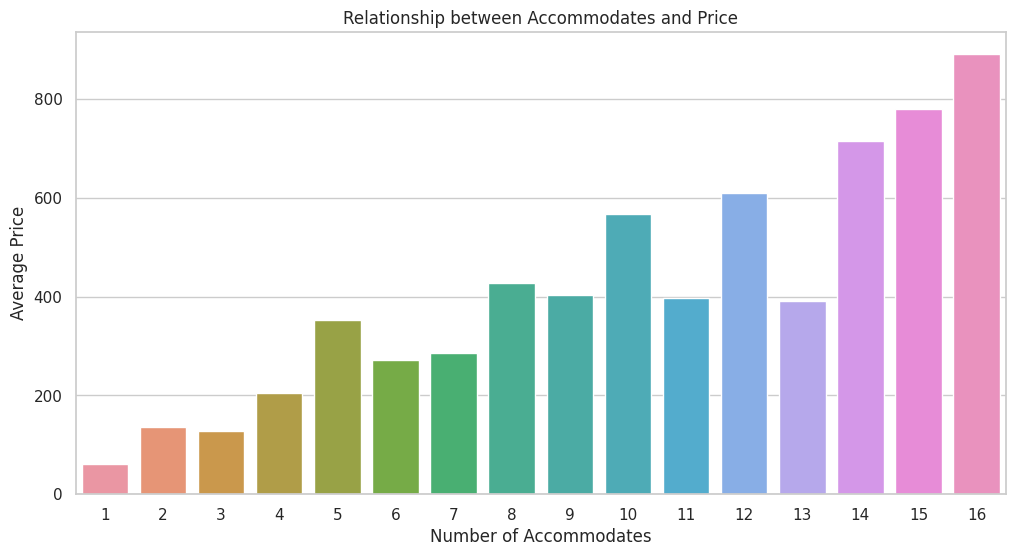

In [ ]:
# Find the most popular number of accommodates in the listings dataset
most_popular_accommodates = listings['accommodates'].value_counts().idxmax()
print(f"The most popular number of accommodates in the listings dataset is: {most_popular_accommodates}\n\n")

# Visualize the relationship between accommodates and price
average_price_per_accommodation_size = listings.groupby('accommodates')['price'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='accommodates', y='price', data=average_price_per_accommodation_size)
plt.xlabel('Number of Accommodates')
plt.ylabel('Average Price')
plt.title('Relationship between Accommodates and Price')
plt.show()

## List of Top Amenities

In [ ]:
import re

# Extract amenities and create a new dataframe with one amenity per row
amenities_data = listings['amenities'].str.strip('{}').str.split(',').apply(pd.Series).stack().reset_index(drop=True).to_frame('amenity')

# Clean up the amenities by removing quotes and non-alphanumeric characters
amenities_data['amenity'] = amenities_data['amenity'].str.replace('"', '').str.strip().apply(lambda x: re.sub(r'^\W+|\W+$', '', x))

# Calculate the occurrences of each amenity
amenity_counts = amenities_data['amenity'].value_counts().reset_index().rename(columns={'index': 'amenity', 'amenity': 'count'})

# Display the top 10 most common amenities
print(amenity_counts.head(20))

                     amenity  count
0                Smoke alarm  10469
1                    Kitchen  10069
2                 Essentials   9682
3                       Wifi   9559
4    Long term stays allowed   8990
5   Free parking on premises   8676
6                 Hair dryer   8601
7                    Hangers   8480
8      Carbon monoxide alarm   8310
9                       Iron   8282
10         Fire extinguisher   8200
11                 Hot water   8056
12     Dishes and silverware   8031
13                   Shampoo   7894
14            Cooking basics   7602
15                   Heating   7586
16              Refrigerator   7561
17             Self check-in   7396
18                 Microwave   7311
19                Bed linens   6821


## Compare Negative and Positive Comments for Each Topic

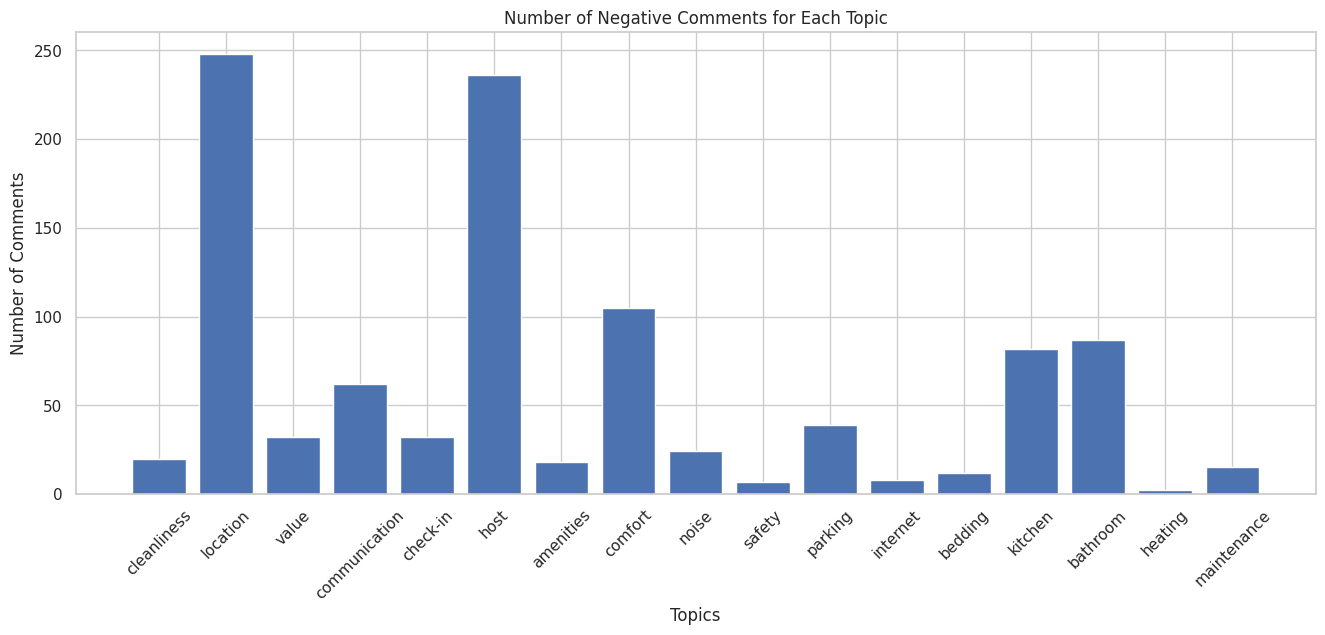

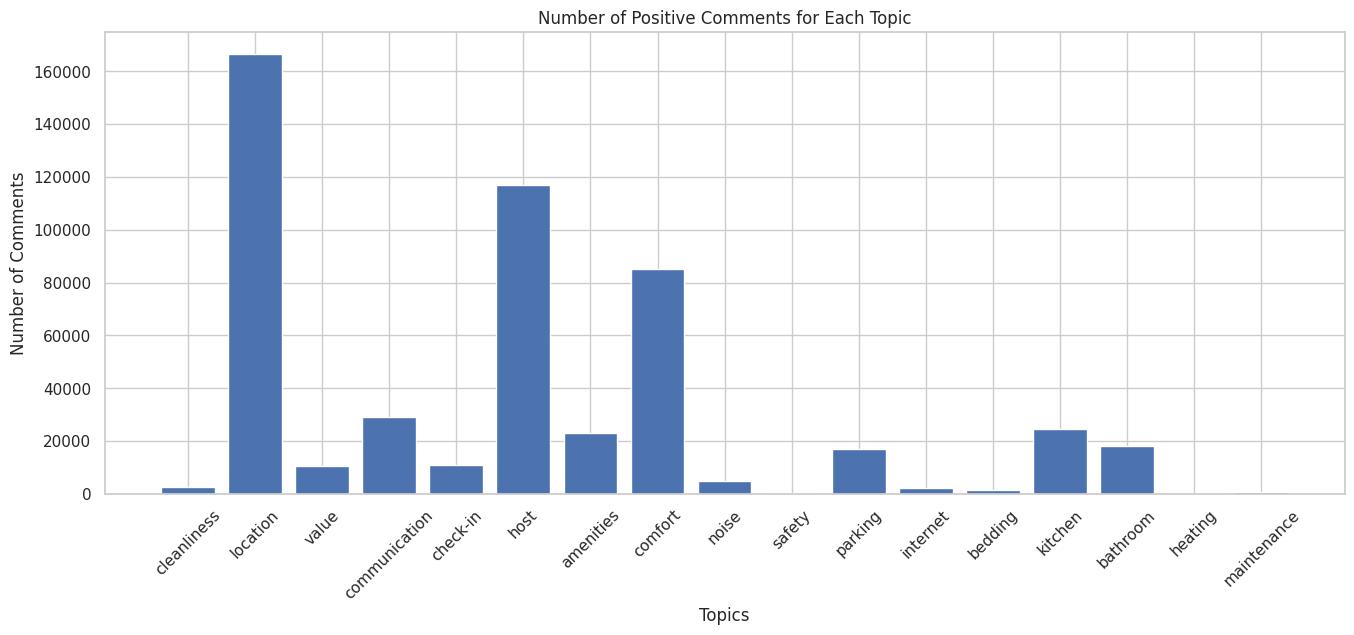

In [ ]:
# Merge the datasets
merged_data = reviews.merge(listings[['id', 'review_scores_rating']], left_on='listing_id', right_on='id', how='left')

# Filter negative reviews
threshold = 4
negative_reviews = merged_data[merged_data['review_scores_rating'] < threshold]
positive_reviews = merged_data[merged_data['review_scores_rating'] > threshold]

# Define the topics
topics = ['cleanliness', 'location', 'value', 'communication', 'check-in', 'host', 'amenities', 'comfort',
          'noise', 'safety', 'parking', 'internet', 'bedding', 'kitchen', 'bathroom', 'heating', 'maintenance']

# Count the number of negative comments for each topic
topic_negative_counts = {}
topic_positive_counts = {}
for topic in topics:
    topic_negative_counts[topic] = negative_reviews['comments'].str.contains(topic, case=False, na=False).sum()
    topic_positive_counts[topic] = positive_reviews['comments'].str.contains(topic, case=False, na=False).sum()

# Plot the results on a bar chart with increased width and rotated x-axis labels
plt.figure(figsize=(16, 6))
plt.bar(topic_negative_counts.keys(), topic_negative_counts.values())
plt.title('Number of Negative Comments for Each Topic')
plt.xlabel('Topics')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.show()
print("\n")
plt.figure(figsize=(16, 6))
plt.bar(topic_positive_counts.keys(), topic_positive_counts.values())
plt.title('Number of Positive Comments for Each Topic')
plt.xlabel('Topics')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.show()